In [6]:
import numpy as np
import tensorflow as tf
import jieba
import keras
from keras import utils
from keras.preprocessing import sequence
from keras.backend.tensorflow_backend import set_session
from keras.layers import Embedding,Dense,GlobalAveragePooling1D,Input,Activation
from keras.models import Model,Sequential
import matplotlib.pyplot as plt


In [7]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8  # 比例
config.gpu_options.allow_growth = True    # 按需
set_session(tf.Session(config=config))

In [8]:
def get_label_sentence(filename):
    """
    input file content:
    体育 sentence_1
    ...
    娱乐 sentence_n
    
    output dict:
    {
    "体育": [sentence_1, sentence_2, ..., sentence_n],
    "娱乐":[...],
    ...
    }
    """
    label_sentence_dic = {}    # 定义一个标签：样本的字典
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            label, sentence = line.strip().split('\t')
            if label not in label_sentence_dic:
                label_sentence_dic[label] = [sentence]
            else:
                label_sentence_dic[label].append([sentence])
    return label_sentence_dic
        
# 根据label_sentence_dic 划分训练集和测试集，可以不用在这里分
def save2file(label_sentences_dict, train_ratio, training_file, testing_file):
    data_out_training = open(training_file,'w',encoding='utf8')
    data_out_testing = open(testing_file,'w',encoding='utf8')
    for label in label_sentences_dict:
        sentences = label_sentences_dict[label]
        np.random.shuffle(sentences)
        for i in range(0,len(sentences)):
            if i < int(train_ratio*len(sentences)):
                data_out_training.write(label+':'+sentences[i]+'\n')
            else:
                data_out_testing.write(label+':'+sentences[i]+'\n')
    data_out_training.close()
    data_out_testing.close()

def filter_word_frec_dic(word_frec_dic, min_num):
    word_frec_dic_new = {}
    for word, num in word_frec_dic.items():
        if num >= min_num:
            word_frec_dic_new[word] = num
    return word_frec_dic_new
    
# 获得词频字典
def get_word_frec_dic(filename):
    label_set = set()
    # 统计文档词频
    word_freq_dic = {}
    special_symbol = ['', '\t', ',', ':', ';', '。']
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            label, sentence = line.strip().split('\t')
            if len(label) != 0:
                label_set.add(label) 
            word_list = jieba.cut(sentence)   # 生成器
            for word in word_list:
                word = word.strip()
                if word in special_symbol:  # 过滤特殊符号
                    continue
                if word not in word_freq_dic:
                    word_freq_dic[word] = 1
                else:
                    word_freq_dic[word] += 1
    return word_freq_dic, label_set

# 不需要考虑顺序，为Word、label建立索引
def get_word_label_2index(word_frec_dic, label_set):
    """
    input:
        word_frac_dic: {"word1":123, "word2":345, ...}
        label_set: {"体育", "娱乐", ...}
    
    output:
        word2index: {"word1":0, "word2":1, ...}
        label2index: {"体育":0, "娱乐":1, ...}
    """
    word2index = {}
    lenth = len(word_frec_dic)
    for i, word in zip(range(lenth), word_frec_dic):
        word2index[word] = i

    label2index = {}
    for i, label in zip(range(len(label_set)), label_set):
        label2index[label] = i
    return word2index, label2index


def create_trainingdata(filename, word2index, label2index, padding_len=300):
    with open(filename, 'r', encoding='utf-8') as f:
        training_data = []
        for line in f:
            label, sentence = line.strip().split('\t')
            words = jieba.cut(sentence)
            sentence_word_index = [word2index[word] for word in words if word in word2index]
            label = [label2index[label]]
            training_data.append((sentence_word_index, label)) # 将特征和标签放一起读取 然后随机打乱

    np.random.shuffle(training_data)

    X_train = []
    y_train = []
    for feas, label in training_data:
        X_train.append(feas)
        y_train.append(label)

    # 相当于将词汇统一为300，多出的删除，少的补上0
    X_train = sequence.pad_sequences(X_train, maxlen=padding_len, padding='post', truncating='post')
    y_train = utils.to_categorical(y_train, num_classes=10)   # onehot
    
    X_train = np.array(X_train)  # 注意这里不是onehot
    y_train = np.array(y_train)
    return X_train, y_train

# model
def fasttext(vocab_size, embedding_dim, label_num):
    model = Sequential() 
    model.add(Embedding(vocab_size, embedding_dim, input_length=300))
    model.add(GlobalAveragePooling1D())
    # model.add(Dense(label_num*5))  # 如果加上这一层，效果不好
    model.add(Dense(label_num))
    model.add(Activation(activation='sigmoid'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model


def save2file(word2index, filename):
    data_out = open(filename, 'w', encoding='utf8')
    for word, index in word2index.items():
        data_out.write(word + ':'+str(index) + '\n')
    data_out.close()

"""   
def train(filename, min_num=10, embedding_dim=300,batch_size=256, epochs=30):
    
    word_freq_dic, label_set = get_word_frec_dic(filename)
    word_freq_filter_dic = filter_word_frec_dic(word_freq_dic, min_num)
    word2index, label2index = get_word_label_2index(word_freq_filter_dic, label_set)
    
    # 此处需要把word2index和label2index存成文本
    # save2file(word2index,'./data/word2index.txt')
    # save2file(label2index,'./data/label2index.txt')

    # 读取训练数据集 返回可以直接入模型的特征和标签
    X_train, y_train = create_trainingdata(filename, word2index, label2index, padding_len=300)
    print('X_train[0] is: ', X_train[0])
    print('y_train.shape is: ', y_train.shape)

    vocab_size = len(word2index)    
    model = fasttext(vocab_size, embedding_dim, len(label2index))
    # # 通过fit的callbacks参数将回调函数传入模型中，这个参数接收一个回调函数列表，你可以传入任意个回调函数
    # callback_lists = [
    #     keras.callbacks.EarlyStopping(monitor = 'acc',  # 监控模型的验证精度
    #                                   patience = 1,),   # 如果精度在多于一轮的时间（即两轮）内不再改善，就中断训练
    #     # ModelCheckpoint用于在每轮过后保存当前权重
    #     keras.callbacks.ModelCheckpoint(filepath = 'news_classfication_textcnn.h5', # 目标文件的保存路径
    #                                     # 这两个参数的意思是，如果val_loss没有改善，那么不需要覆盖模型文件，
    #                                     # 这就可以始终保存在训练过程中见到的最佳模型
    #                                     monitor = 'val_loss', save_best_only = True,)
    # ]
    # history = model.fit(training_feas,training_labels,batch_size=256,epochs=30,validation_split=0.3,callbacks=callback_lists)
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.3)
    model.save('fasttext_news_cf.model')
    plot(history)
 """   

def plot(history):
    plt.subplot(211)
    plt.title("accuracy")
    plt.plot(history.history["acc"], color="r", label="train")
    plt.plot(history.history["val_acc"], color="b", label="validation")
    plt.legend(loc="best")

    plt.subplot(212)
    plt.title("loss")
    plt.plot(history.history["loss"], color="r", label="train")
    plt.plot(history.history["val_loss"], color="b", label="validation")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


In [9]:
filename = './data/cnews_train.txt'
min_num = 10    # 最小词频
embedding_dim = 200
batch_size = 256
epochs = 30

In [10]:
word_freq_dic, label_set = get_word_frec_dic(filename)
word_freq_filter_dic = filter_word_frec_dic(word_freq_dic, min_num)
word2index, label2index = get_word_label_2index(word_freq_filter_dic, label_set)
# 读取训练数据集 返回可以直接入模型的特征和标签
X_train, y_train = create_trainingdata(filename, word2index, label2index, padding_len=300)

In [11]:
vocab_size = len(word2index)    
label_num = len(label2index)

In [12]:
model = fasttext(vocab_size, embedding_dim, label_num)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 200)          3730200   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2010      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 3,732,210
Trainable params: 3,732,210
Non-trainable params: 0
_________________________________________________________________


In [15]:
print(X_train.shape)
print(y_train.shape)
print(len(word2index))

(5000, 300)
(5000, 10)
18651


In [20]:
# Embedding(vocab_size, embedding_dim, input_length=300)

In [21]:
# model.get_layer(index=0).output

In [25]:
# 通过fit的callbacks参数将回调函数传入模型中，这个参数接收一个回调函数列表，你可以传入任意个回调函数
callback_lists = [
    keras.callbacks.EarlyStopping(monitor = 'acc',  # 监控模型的验证精度
                                  patience = 5,),   # 如果精度在多于一轮的时间（即两轮）内不再改善，就中断训练
    # ModelCheckpoint用于在每轮过后保存当前权重
    keras.callbacks.ModelCheckpoint(filepath = 'fasttext_news_cf.model', # 目标文件的保存路径
                                    # 这两个参数的意思是，如果val_loss没有改善，那么不需要覆盖模型文件，
                                    # 这就可以始终保存在训练过程中见到的最佳模型
                                    monitor = 'val_loss', save_best_only = True,)
]

In [26]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=0.3, callbacks=callback_lists)

Train on 3500 samples, validate on 1500 samples
Epoch 1/30
3500/3500 [==============================] - 0s 61us/step - loss: 2.1018 - acc: 0.6326 - val_loss: 2.0969 - val_acc: 0.6140
Epoch 2/30
3500/3500 [==============================] - 0s 60us/step - loss: 2.0507 - acc: 0.6409 - val_loss: 2.0508 - val_acc: 0.6207
Epoch 3/30
3500/3500 [==============================] - 0s 60us/step - loss: 1.9994 - acc: 0.6583 - val_loss: 2.0045 - val_acc: 0.6320
Epoch 4/30
3500/3500 [==============================] - 0s 60us/step - loss: 1.9465 - acc: 0.6740 - val_loss: 1.9562 - val_acc: 0.6520
Epoch 5/30
3500/3500 [==============================] - 0s 59us/step - loss: 1.8902 - acc: 0.6894 - val_loss: 1.9030 - val_acc: 0.6673
Epoch 6/30
3500/3500 [==============================] - 0s 60us/step - loss: 1.8270 - acc: 0.7063 - val_loss: 1.8412 - val_acc: 0.6793
Epoch 7/30
3500/3500 [==============================] - 0s 60us/step - loss: 1.7531 - acc: 0.7260 - val_loss: 1.7670 - val_acc: 0.6940
Epoch 8

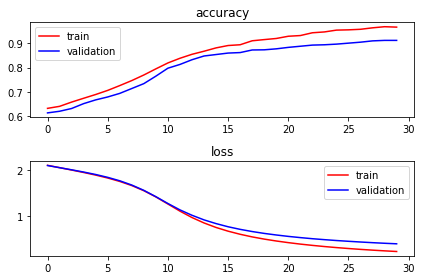

In [27]:
plot(history)

In [28]:
test_file = './data/cnews_test.txt'
X_test, y_test = create_trainingdata(test_file, word2index, label2index, padding_len=300)

In [30]:
from keras.models import load_model
model = load_model('fasttext_news_cf.model')
score = model.evaluate(X_test, y_test)   # Returns the loss value & metrics values
print(score)

4500/4500 [==============================] - 0s 76us/step
[0.4003586342599657, 0.9082222221692403]


In [13]:
label_sentence_dic, label_set = get_label_sentence(filename)

In [15]:
len(label_sentence_dic)

10

In [19]:
for k in label_sentence_dic:
    print(k, len(label_sentence_dic[k]))

体育 500
娱乐 500
家居 500
房产 500
教育 500
时尚 500
时政 500
游戏 500
科技 500
财经 500


In [30]:
sequence.pad_sequences([[1,2,3,3,3,2,8,8,8,8,8,8,77,8,8],[4,5,5]], maxlen=10, padding='post', truncating='post')

array([[1, 2, 3, 3, 3, 2, 8, 8, 8, 8],
       [4, 5, 5, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [28]:
utils.to_categorical(range(10), num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
# Embedding 层